# Bar Path Tracker:

## Imports

In [2]:
import numpy as np
import os
import sys
import pandas
import cv2

repo_path = r'C:\Users\ellio\OneDrive\Desktop\GitHub\bar_path_tracker'

## Basic Utils:

In [3]:
def open_and_display_video(path:str) -> None:
    
    vid = cv2.VideoCapture(os.path.join(repo_path, path))
    if (vid.isOpened()== False): 
        print("Error opening video stream or file")
    else:
        print(f"Playing video at {path}. Hit 'q' to quit.")
    
    while(vid.isOpened()):
        # Capture frame-by-frame
        ret, frame = vid.read()
        
        if ret == True:
            cv2.imshow('Frame',frame)
            if cv2.waitKey(25) & 0xFF == ord('q'):
                break
        else: 
            break
    # When everything done, release the video capture object
    vid.release()
    # Closes all the frames
    cv2.destroyAllWindows()
    
open_and_display_video(r'data\example_videos\squat_example.mp4')

Playing video at data\example_videos\squat_example.mp4. Hit 'q' to quit.


In [4]:
tracker = cv2.TrackerCSRT_create()
tracker_type = "CSRT"

In [301]:
# Get the video file and read it

bar_path = []
times = []

cv2.destroyAllWindows()
video = cv2.VideoCapture(os.path.join(repo_path, r'data\example_videos\bench_example.mp4'))
ret, frame = video.read()
if not ret:
    print('cannot read the video')

frame_height, frame_width = frame.shape[:2]

frame_height = 2000
frame_width = 2000

# Resize the video for a more convinient view
frame = cv2.resize(frame, [frame_width//2, frame_height//2])

mask = np.zeros_like(frame)

# Initialize video writer to save the results
output = cv2.VideoWriter(f'{tracker_type}.mp4', 
                         cv2.VideoWriter_fourcc(*'XVID'), 60.0, 
                         (frame_width//2, frame_height//2), True)

# Select the bounding box in the first frame
bbox = cv2.selectROI(frame, False)
start_bbox = list(bbox)
previous_c = (int(bbox[0] + bbox[2]/2), int(bbox[1] + bbox[3]/2))

bar_path.append(previous_c)

ret = tracker.init(frame, bbox)
# Start tracking

while True:
    ret, frame = video.read()
    if not ret:
        break

    frame = cv2.resize(frame, [frame_width//2, frame_height//2])
    timer = cv2.getTickCount()
    ret, bbox = tracker.update(frame)
    fps = cv2.getTickFrequency() / (cv2.getTickCount() - timer)
    if ret:
        p1 = (int(bbox[0]), int(bbox[1]))
        p2 = (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3]))

        c = (int(bbox[0] + bbox[2]/2), int(bbox[1] + bbox[3]/2))
        bar_path.append([c[0], c[1]])
        times.append(timer)

        if c[1] - previous_c[1] < 0:
            color = (0,0,255)
        else:
            color = (0,255,0)



        mask = cv2.line(mask, previous_c, c, color, 5)
        frame = cv2.rectangle(frame, p1, p2, (255,255,255), 2, 1)

    else:
        cv2.putText(frame, "Tracking failure detected", (100,80), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.75,(255,0,0),2)
    cv2.putText(frame, tracker_type + " Tracker", (0,20),
                cv2.FONT_HERSHEY_SIMPLEX, 0.75, (255,0,0),2)
    cv2.putText(frame, "FPS : " + str(int(fps)), (0,50), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.75, (255,0,0),2)
    cv2.imshow("Tracking", cv2.add(frame, mask))
    output.write(cv2.add(frame, mask))
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

    previous_c = c
        
video.release()
output.release()
cv2.destroyAllWindows()

'\nd_xx = d_x[1:] - d_x[:-1]\nd_tt = d_t[1:] - d_t[:-1]\nspeed_t = speeds[1:] - speeds[:-1]\n\naccelerations = speed_t/d_t[1:]\n\naxs[3].plot(times[2:], accelerations, c = "r", linewidth  = 1)\naxs[3].set_ylabel("Force")\naxs[3].set_xlabel("Time")\naxs[3].set_xticks([])\naxs[3].set_yticks([])\n'

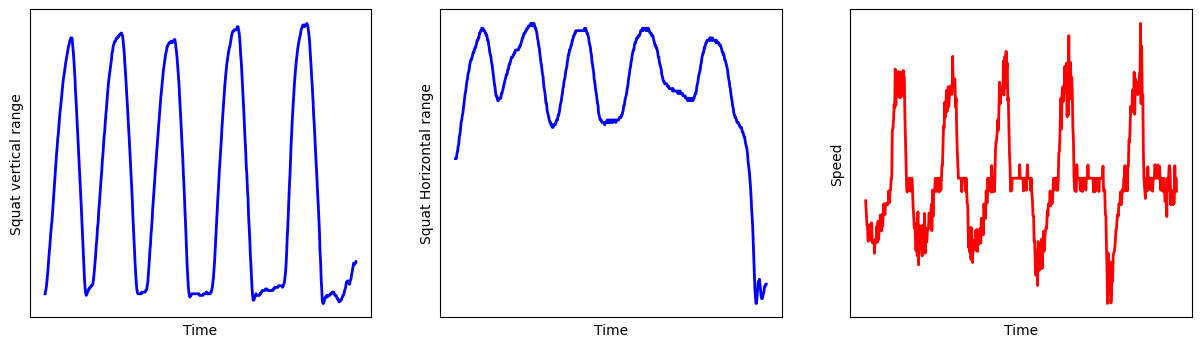

In [302]:
import matplotlib.pyplot as plt
bar_path = np.array(bar_path)

f, axs = plt.subplots(1,3, figsize = (15,4))

axs[0].plot(times, bar_path[1:,1], c = "b", linewidth  = 2)
axs[0].set_ylabel("Squat vertical range")
axs[0].set_xlabel("Time")
axs[0].set_xticks([])
axs[0].set_yticks([])

axs[1].plot(times, bar_path[1:,0], c = "b", linewidth  = 2)
axs[1].set_ylabel("Squat Horizontal range")
axs[1].set_xlabel("Time")
axs[1].set_xticks([])
axs[1].set_yticks([])

times = np.array(times)

d_x = np.array(bar_path[2:,1]-bar_path[1:-1,1])
d_t = np.array(times[:-1] - times[1:])

speeds = d_x / d_t 

axs[2].plot(times[1:], speeds, c = "r", linewidth  = 2)
axs[2].set_ylabel("Speed")
axs[2].set_xlabel("Time")
axs[2].set_xticks([])
axs[2].set_yticks([])


"""
d_xx = d_x[1:] - d_x[:-1]
d_tt = d_t[1:] - d_t[:-1]
speed_t = speeds[1:] - speeds[:-1]

accelerations = speed_t/d_t[1:]

axs[3].plot(times[2:], accelerations, c = "r", linewidth  = 1)
axs[3].set_ylabel("Force")
axs[3].set_xlabel("Time")
axs[3].set_xticks([])
axs[3].set_yticks([])
"""

5


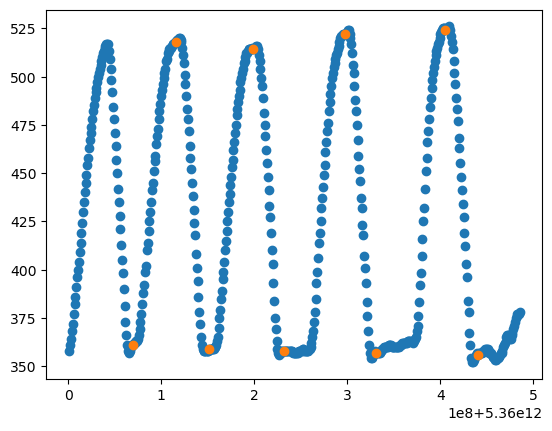

In [303]:
from scipy.signal import savgol_filter

v_displacements = bar_path[1:,1]
norm_v_displacements = (v_displacements - v_displacements.min())/(v_displacements.max() - v_displacements.min())
v_smoothed = savgol_filter(norm_v_displacements, 51, 5)

peaks = scipy.signal.find_peaks(v_smoothed, height=0.5)
troughs = scipy.signal.find_peaks(1 - v_smoothed, height=0.5)

num_peaks = len(peaks[0])
num_troughs = len(troughs[0])
num_reps = min(num_peaks, num_troughs)

tops = list(zip(peaks[0], peaks[1]['peak_heights']))
bottoms = list(zip(troughs[0], -1 * troughs[1]['peak_heights']))

heights = np.array([])
heights = np.append(heights, -1*troughs[1]['peak_heights'])
heights = np.append(heights, peaks[1]['peak_heights'])

tp_times = np.array([])
tp_times = np.append(tp_times, troughs[0])
tp_times = np.append(tp_times, peaks[0])

x = sorted(zip(tp_times, heights))


turning_points = {}

prev_sign = not heights[0] < 0

for i, (t, h) in enumerate(x):
    if i == 0:
        t = 0
    sign = h < 0
    if sign != prev_sign:
        turning_points[int(t)] = h
        prev_h = h
    else:
        if sign:
            prev_h = min(h, prev_h)
        else:
            prev_h = max(h, prev_h)
    
    prev_sign = sign

extreme_times = list(turning_points.keys())
extreme_heights = list(turning_points.values())

if extreme_times[-1] < 0:
    turning_points[max(times)] = v_displacements[-1]

extreme_times = list(turning_points.keys())
extreme_heights = list(turning_points.values())

plt.scatter(times, v_displacements)
plt.scatter(times[extreme_times], v_displacements[extreme_times])
print(num_reps)

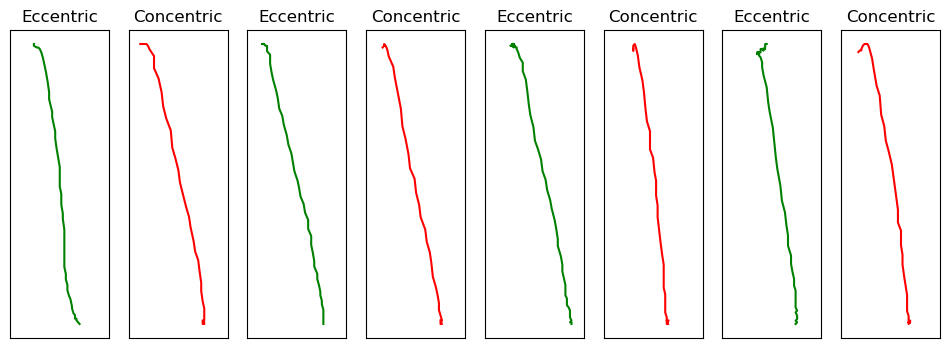

In [309]:
f, axs = plt.subplots(1, len(turning_points)-1, figsize = (12,4))


x_displacements = bar_path[1:,0]
y_displacements = bar_path[1:,1]

count = 0

for i in range(len(turning_points)-1):

    if extreme_heights[i] < 0:
        c = "green"
        title = "Eccentric"
    else:
        c = "red"
        title = "Concentric"

    axs[i].set_xticks([])
    axs[i].set_yticks([])
    axs[i].plot(x_displacements[extreme_times[i]: extreme_times[i+1]],  -1 * y_displacements[extreme_times[i]: extreme_times[i+1]], c = c)


    # fix me

    axs[i].set_xlim(np.mean(x_displacements[extreme_times[i]: extreme_times[i+1]]) - start_bbox[2]/6, 
                    np.mean(x_displacements[extreme_times[i]: extreme_times[i+1]]) + start_bbox[2]/6)
    axs[i].set_title(title)
    
